In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv("C:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data\\hourly features formula one.csv")

# Cleanup prediction columns
pred_cols = ['0.6 percent prediction', '1 percent prediction', '1.5 percent prediction', 'probability']
for col in pred_cols:
    if col not in df.columns:
        df[col] = 0.0
df[pred_cols] = df[pred_cols].fillna(0)

# Encode target labels
encoder = LabelEncoder()
df["target"] = encoder.fit_transform(df["forward regime"].astype(str))

print(df)

      Unnamed: 0              date     open     high      low    close  \
0              0    4/22/2025 3:00  3471.10  3475.10  3466.80  3475.10   
1              1    4/22/2025 4:00  3472.57  3494.08  3472.28  3487.27   
2              2    4/22/2025 5:00  3487.55  3487.94  3479.20  3484.67   
3              3    4/22/2025 6:00  3484.95  3495.01  3474.14  3493.26   
4              4    4/22/2025 7:00  3492.59  3499.45  3477.36  3479.42   
...          ...               ...      ...      ...      ...      ...   
2937        2937  10/10/2025 11:00  3995.56  3999.84  3990.61  3993.68   
2938        2938  10/10/2025 12:00  3993.50  3999.70  3983.56  3986.96   
2939        2939  10/10/2025 13:00  3987.35  3993.31  3980.01  3985.40   
2940        2940  10/10/2025 14:00  3985.33  3997.99  3975.26  3978.33   
2941        2941  10/10/2025 15:00  3978.64  3993.93  3970.39  3989.12   

      volume  past_ret_1h  past_ret_2h  past_ret_4h  past_ret_8h  \
0         36    -0.046091    -0.046091    -

In [18]:
base_features = [
    "volume",
    "0.6 percent prediction", "1 percent prediction",
    "1.5 percent prediction", 
    "past_ret_1h",
]

#generated_features = [
#    c for c in df.columns if any(key in c for key in [
#        "rmean_", "rstd_", "pct_ch_", "hour", "day", "month",
#        "sin", "cos", "dayofweek"
#    ])
#]

feature_cols = [c for c in base_features if c in df.columns]  # + generated_features
#feature_cols=[c for c in base_features]
print(f"Total features used: {len(feature_cols)}")

X_all = df[feature_cols].fillna(0).values
y_all = df["target"].values

Total features used: 5


# computing class weights

In [19]:
import torch
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example class counts from your dataset
# IMPORTANT → order must match label encoding: 0=downward, 1=range, 2=upward
class_counts = np.array([303, 1476, 374], dtype=np.float32)

# Inverse frequency weights
class_weights = 1.0 / class_counts

# Normalize (optional but cleaner)
class_weights = class_weights / class_weights.sum()

# Convert to torch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


In [20]:
split_idx = int(len(df) * 0.8)

X_train_raw = X_all[:split_idx]
y_train_raw = y_all[:split_idx]

X_test_raw = X_all[split_idx:]
y_test_raw = y_all[split_idx:]

In [21]:
scaler = StandardScaler()
scaler.fit(X_train_raw)

X_train_scaled = scaler.transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

In [22]:
def create_sequences(X, y, seq_len=4): # also use 8
    seqs, labels = [], []
    for i in range(len(X) - seq_len):
        seqs.append(X[i:i+seq_len].T)  # (features, seq_len)
        labels.append(y[i + seq_len])
    return np.array(seqs), np.array(labels)


SEQ_LEN = 4

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_raw, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(
    np.vstack([X_train_scaled[-SEQ_LEN:], X_test_scaled]),
    np.concatenate([y_train_raw[-SEQ_LEN:], y_test_raw]),
    SEQ_LEN
)

In [23]:
def print_distribution(y, title=""):
    counts = Counter(y)
    print(f"\n--- {title} ---")
    for c, n in counts.items():
        print(f"class {c} ({encoder.inverse_transform([c])[0]}): {n} ({n/len(y):.2%})")

print_distribution(y_train_seq, "Training Set Distribution")
print_distribution(y_test_seq, "Test Set Distribution")


--- Training Set Distribution ---
class 0 (downward): 382 (16.26%)
class 1 (range): 1556 (66.24%)
class 2 (upward): 411 (17.50%)

--- Test Set Distribution ---
class 1 (range): 389 (66.04%)
class 2 (upward): 140 (23.77%)
class 0 (downward): 60 (10.19%)


In [24]:
import torch
import numpy as np

# Example class counts from your dataset
# IMPORTANT → order must match label encoding: 0=downward, 1=range, 2=upward
class_counts = np.array([303, 1476, 374], dtype=np.float32)

# Inverse frequency weights
class_weights = 1.0 / class_counts

# Normalize (optional but cleaner)
class_weights = class_weights / class_weights.sum()

# Convert to torch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


# weighted loss random sampler

In [25]:
X_train_t = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_t = torch.tensor(y_train_seq, dtype=torch.long)

X_test_t = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_t = torch.tensor(y_test_seq, dtype=torch.long)


from torch.utils.data import WeightedRandomSampler

# y_train must be your training labels (not all dataset labels)
train_labels = y_train_t
class_counts = Counter(y_train_seq)
# Build per-sample weights using class weights
sample_weights = np.array([class_weights[label] for label in train_labels])

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=128,
    sampler=sampler,     # <--- IMPORTANT
    drop_last=False
)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=128, shuffle=False)

In [26]:
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation, padding, dropout=0.3): # instead of 0.3
        super().__init__()

        self.conv1 = weight_norm(
            nn.Conv1d(in_ch, out_ch, k, padding=padding, dilation=dilation)
        )
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(
            nn.Conv1d(out_ch, out_ch, k, padding=padding, dilation=dilation)
        )
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.drop1(self.relu1(self.chomp1(self.conv1(x))))
        y = self.drop2(self.relu2(self.chomp2(self.conv2(y))))
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(y + res)

class TCNClassifier(nn.Module):
    def __init__(self, num_inputs, num_classes):
        super().__init__()
        channels = [32, 128, 256] # third one changed from 128 to 256

        layers = []
        for i, out_ch in enumerate(channels):
            in_ch = num_inputs if i == 0 else channels[i - 1]
            dilation = 2 ** i
            padding = (3 - 1) * dilation
            layers.append(TemporalBlock(in_ch, out_ch, 3, dilation, padding))
        self.tcn = nn.Sequential(*layers)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(channels[-1], num_classes)

    def forward(self, x):
        y = self.tcn(x)
        y = self.pool(y).squeeze(-1)
        return self.fc(y)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCNClassifier(num_inputs=X_train_t.shape[1], num_classes=len(encoder.classes_)).to(device)

# Weighted CrossEntropyLoss
class_weights = torch.tensor(
    [1 / class_counts[i] for i in sorted(class_counts.keys())],
    dtype=torch.float32
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    train_preds, train_labels = [], []
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        train_preds += out.argmax(1).cpu().numpy().tolist()
        train_labels += yb.cpu().numpy().tolist()

    train_loss = total_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    val_loss_running = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)

            val_loss_running += loss.item() * xb.size(0)
            val_preds += out.argmax(1).cpu().numpy().tolist()
            val_labels += yb.cpu().numpy().tolist()

    val_loss = val_loss_running / len(test_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 1/50 - Train Loss 0.9936, Acc 0.3695 | Val Loss 1.4459, Acc 0.1698
Epoch 2/50 - Train Loss 0.9425, Acc 0.3823 | Val Loss 1.2610, Acc 0.2224
Epoch 3/50 - Train Loss 0.9346, Acc 0.3985 | Val Loss 1.2314, Acc 0.2258
Epoch 4/50 - Train Loss 0.9229, Acc 0.4232 | Val Loss 1.1845, Acc 0.2275
Epoch 5/50 - Train Loss 0.9235, Acc 0.4006 | Val Loss 1.1412, Acc 0.2428
Epoch 6/50 - Train Loss 0.9244, Acc 0.4078 | Val Loss 1.1432, Acc 0.2411
Epoch 7/50 - Train Loss 0.9092, Acc 0.4291 | Val Loss 1.1498, Acc 0.2445
Epoch 8/50 - Train Loss 0.9206, Acc 0.4095 | Val Loss 1.1323, Acc 0.2428
Epoch 9/50 - Train Loss 0.8998, Acc 0.4274 | Val Loss 1.1498, Acc 0.2428
Epoch 10/50 - Train Loss 0.9123, Acc 0.4155 | Val Loss 1.1277, Acc 0.2445
Epoch 11/50 - Train Loss 0.9095, Acc 0.4202 | Val Loss 1.0934, Acc 0.2445
Epoch 12/50 - Train Loss 0.9026, Acc 0.4232 | Val Loss 1.1449, Acc 0.2394
Epoch 13/50 - Train Loss 0.8904, Acc 0.4300 | Val Loss 1.0763, Acc 0.2954
Epoch 14/50 - Train Loss 0.8871, Acc 0.4466 | V


Final Test Accuracy: 0.32767402376910015

Classification Report:

              precision    recall  f1-score   support

    downward       0.21      0.10      0.14        60
       range       0.65      0.18      0.29       389
      upward       0.26      0.83      0.39       140

    accuracy                           0.33       589
   macro avg       0.37      0.37      0.27       589
weighted avg       0.51      0.33      0.30       589



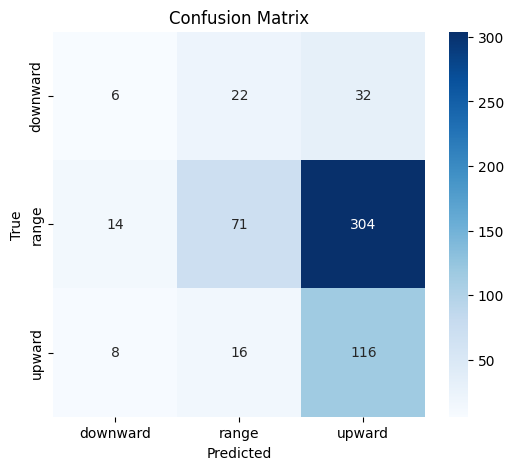

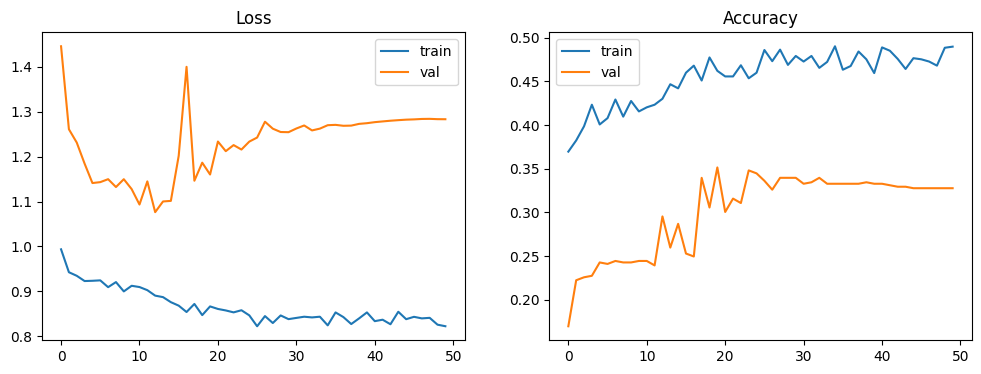

In [30]:
print("\nFinal Test Accuracy:", accuracy_score(val_labels, val_preds))
print("\nClassification Report:\n")
print(classification_report(val_labels, val_preds, target_names=encoder.classes_))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot Loss/Accuracy curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"], label="val")
plt.title("Accuracy")
plt.legend()
plt.show()